**Forecasting Bankruptcies in Major Japanese Cities Using Gaussian Process Regression**

Kosuke Fujioka

2111703

**Introduction**

Although various factors can be assumed to cause the bankruptcy of a single company, there is no doubt that the deterioration of the macro environment to which a company belongs, in other words, a recession, has a certain degree of impact on bankruptcy.  Therefore, the number of bankruptcies in a given period in a specific region is a useful indicator of its economic trends. In this report, we attempt to predict the number of bankruptcies in a particular period based on partial data on past and future bankruptcies. Bankruptcies are based on five major cities in Japan (Tokyo, Osaka, Aichi, Kanagawa, Saitama), and The main research question is how to predict the rise in the number of bankruptcies in these cities during the financial crisis of 2008-2009 and the gradual rise during the pandemic that began around March 2020. We focus on the gaussian process discussed in the lecture as the analytical method for forecasting. The advantages of gaussian process regression in this forecasting are that it is a nonparametric analytical method and thus can flexibly fit nonlinear changes in the number of bankruptcies, and that the error range obtained by the Bayesian inference framework vary according to data-rich and data-poor regions. 

**Data Setup**

In this report, we use time-series data on the number of bankruptcies in the top five regions of Japan in terms of the number of firms (Tokyo, Osaka, Aichi, Kanagawa, and Saitama from top to bottom). The above data are pulled from Japan's official statistical office called e-stat(https://www.e-stat.go.jp/en/node). Although it is possible to utilize the API for e-stat data by registering for an account, in this case the data is stored locally and then used. From e-stat, you can install data that contains the number of bankrupt companies for each month from July 2005 to July 2023 for each city.(https://dashboard.e-stat.go.jp/en/timeSeriesResult?indicatorCode=0701060100000010010) 

In [166]:
#libraries
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import pyplot as pyp

from itertools import product

import numpy as np

from scipy.stats import linregress
from scipy import stats
import scipy as scipy

import statsmodels.api as sm

from sklearn.linear_model import LinearRegression

import seaborn as sns

#read files
Tokyo = pd.read_csv('TimeSeriesResult_20230815153104010_Tokyo.csv')
Osaka = pd.read_csv('TimeSeriesResult_20230815153202824_Osaka.csv')
Aichi = pd.read_csv('TimeSeriesResult_20230815153240617_Aichi.csv')
Kanagawa = pd.read_csv('TimeSeriesResult_20230815153340430_Kanagawa.csv')
Saitama = pd.read_csv('TimeSeriesResult_20230815153423546_Saitama.csv')

After preparing the library to be used in the subsequent analysis, the five csv files for each city is read. 

In [167]:
#July 2005 to July 2023
display(Tokyo.shape)
display(Osaka.shape)
display(Aichi.shape)
display(Kanagawa.shape)
display(Saitama.shape)

(217, 5)

(217, 5)

(217, 5)

(217, 5)

(217, 5)

A total of 217 months of data　from July 2005 to July 2023 is stored.

In [168]:
Tokyo.columns.tolist()

['時点', '地域コード', '地域', '企業倒産件数【件】', '注記']

The first task is to translate the necessary parts of the data, since the data is saved in Japanese this time.

In [169]:
#Translation1
Tokyo.rename(columns={"時点": "period", "地域コード": "area code","地域":"city name","企業倒産件数【件】":"number_of_bankruptcies","注記":"note"}, inplace=True)
Osaka.rename(columns={"時点": "period", "地域コード": "area code","地域":"city name","企業倒産件数【件】":"number_of_bankruptcies","注記":"note"}, inplace=True)
Aichi.rename(columns={"時点": "period", "地域コード": "area code","地域":"city name","企業倒産件数【件】":"number_of_bankruptcies","注記":"note"}, inplace=True)
Kanagawa.rename(columns={"時点": "period", "地域コード": "area code","地域":"city name","企業倒産件数【件】":"number_of_bankruptcies","注記":"note"}, inplace=True)
Saitama.rename(columns={"時点": "period", "地域コード": "area code","地域":"city name","企業倒産件数【件】":"number_of_bankruptcies","注記":"note"}, inplace=True)
Tokyo.columns.tolist()

['period', 'area code', 'city name', 'number_of_bankruptcies', 'note']

In [170]:
#Translation2
Tokyo["period"] = Tokyo["period"].str.replace("年", "-")
Tokyo["period"] = Tokyo["period"].str.replace("月", "")
Tokyo["period"] = pd.to_datetime(Tokyo["period"], format="%Y-%m")

Osaka["period"] = Osaka["period"].str.replace("年", "-")
Osaka["period"] = Osaka["period"].str.replace("月", "")
Osaka["period"] = pd.to_datetime(Osaka["period"], format="%Y-%m")

Aichi["period"] = Aichi["period"].str.replace("年", "-")
Aichi["period"] = Aichi["period"].str.replace("月", "")
Aichi["period"] = pd.to_datetime(Aichi["period"], format="%Y-%m")

Kanagawa["period"] = Kanagawa["period"].str.replace("年", "-")
Kanagawa["period"] = Kanagawa["period"].str.replace("月", "")
Kanagawa["period"] = pd.to_datetime(Kanagawa["period"], format="%Y-%m")

Saitama["period"] = Saitama["period"].str.replace("年", "-")
Saitama["period"] = Saitama["period"].str.replace("月", "")
Saitama["period"] = pd.to_datetime(Saitama["period"], format="%Y-%m")

Tokyo["city name"] = Tokyo["city name"].str.replace("東京都", "Tokyo")
Osaka["city name"] = Osaka["city name"].str.replace("大阪府", "Osaka")
Aichi["city name"] = Aichi["city name"].str.replace("愛知県", "Aichi")
Kanagawa["city name"] = Kanagawa["city name"].str.replace("神奈川県", "Kanagawa")
Saitama["city name"] = Saitama["city name"].str.replace("埼玉県", "Saitama")

Tokyo.head()

,period,area code,city name,number_of_bankruptcies,note
0,2005-07-01,13000,Tokyo,169,NaN
1,2005-08-01,13000,Tokyo,210,NaN
2,2005-09-01,13000,Tokyo,180,NaN
3,2005-10-01,13000,Tokyo,201,NaN
4,2005-11-01,13000,Tokyo,178,NaN


There are a total of five columns, three of which are actually used: "period", "city name", and "number of bankruptcies".

In [171]:
nob1 = pd.concat([Tokyo, Osaka, Aichi, Kanagawa, Saitama])

#Mean
Tokyo_mean = nob1[nob1['city name'] == 'Tokyo'].groupby('city name')['number_of_bankruptcies'].mean()
Osaka_mean = nob1[nob1['city name'] == 'Osaka'].groupby('city name')['number_of_bankruptcies'].mean()
Aichi_mean = nob1[nob1['city name'] == 'Aichi'].groupby('city name')['number_of_bankruptcies'].mean()
Kanagawa_mean = nob1[nob1['city name'] == 'Kanagawa'].groupby('city name')['number_of_bankruptcies'].mean()
Saitama_mean = nob1[nob1['city name'] == 'Saitama'].groupby('city name')['number_of_bankruptcies'].mean()


Means=[Tokyo_mean,Osaka_mean,Aichi_mean,Kanagawa_mean,Saitama_mean]
Means

[city name
 Tokyo    168.815668
 Name: number_of_bankruptcies, dtype: float64,
 city name
 Osaka    127.866359
 Name: number_of_bankruptcies, dtype: float64,
 city name
 Aichi    51.658986
 Name: number_of_bankruptcies, dtype: float64,
 city name
 Kanagawa    47.437788
 Name: number_of_bankruptcies, dtype: float64,
 city name
 Saitama    35.912442
 Name: number_of_bankruptcies, dtype: float64]

First, we check the average number of bankrupt firms in each city; the order of the numbers is the same as that of the number of firms, with tokyo and osaka far outnumbering the other cities.

In [172]:
#Max
Tokyo_max = nob1[nob1['city name'] == 'Tokyo'].groupby('city name')['number_of_bankruptcies'].max()
Osaka_max = nob1[nob1['city name'] == 'Osaka'].groupby('city name')['number_of_bankruptcies'].max()
Aichi_max = nob1[nob1['city name'] == 'Aichi'].groupby('city name')['number_of_bankruptcies'].max()
Kanagawa_max = nob1[nob1['city name'] == 'Kanagawa'].groupby('city name')['number_of_bankruptcies'].max()
Saitama_max = nob1[nob1['city name'] == 'Saitama'].groupby('city name')['number_of_bankruptcies'].max()


Maxes=[Tokyo_max,Osaka_max,Aichi_max,Kanagawa_max,Saitama_max]
Maxes

[city name
 Tokyo    346
 Name: number_of_bankruptcies, dtype: int64,
 city name
 Osaka    237
 Name: number_of_bankruptcies, dtype: int64,
 city name
 Aichi    103
 Name: number_of_bankruptcies, dtype: int64,
 city name
 Kanagawa    80
 Name: number_of_bankruptcies, dtype: int64,
 city name
 Saitama    65
 Name: number_of_bankruptcies, dtype: int64]

Similarly, we also ascertain the maximum number of bankrupt firms in each city, i.e., the value for the month with the most bankruptcies. We see that all of them are approximately twice the average.

/var/folders/_5/f24l1pqx5dg1hk_d0r3fhr_00000gn/T/ipykernel_61308/1104859698.py:11: FutureWarning: Passing 'suffixes' which cause duplicate columns {'note_x', 'area code_x', 'city name_x'} in the result is deprecated and will raise a MergeError in a future version.
  df3=pd.merge(df2,Kanagawa, on='period', how='left')


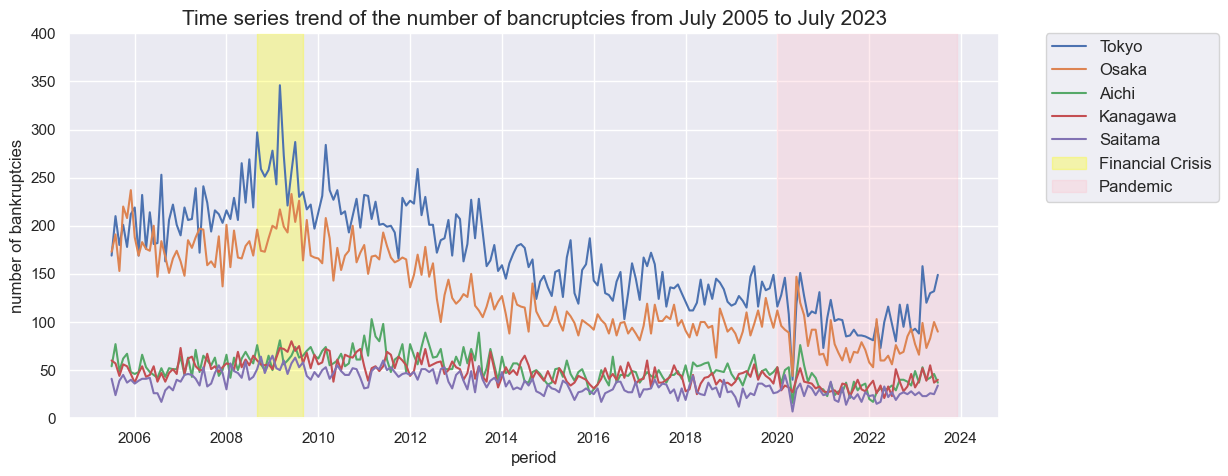

In [187]:
#Time series trend from July 2005 to July 2023

Tokyo.rename(columns={"number_of_bankruptcies":"nob_Tokyo"}, inplace=True)
Osaka.rename(columns={"number_of_bankruptcies":"nob_Osaka"}, inplace=True)
Aichi.rename(columns={"number_of_bankruptcies":"nob_Aichi"}, inplace=True)
Kanagawa.rename(columns={"number_of_bankruptcies":"nob_Kanagawa"}, inplace=True)
Saitama.rename(columns={"number_of_bankruptcies":"nob_Saitama"}, inplace=True)

df1=pd.merge(Tokyo,Osaka, on='period', how='left')
df2=pd.merge(df1,Aichi, on='period', how='left')
df3=pd.merge(df2,Kanagawa, on='period', how='left')
nob2=pd.merge(df3,Saitama, on='period', how='left')


sns.set()


plt.figure(figsize=(12, 5))


plt.xlabel("period")
plt.ylabel("number of bankruptcies")
plt.plot(nob2["period"],nob2["nob_Tokyo"], label='Tokyo')
plt.plot(nob2["period"],nob2["nob_Osaka"], label='Osaka')
plt.plot(nob2["period"],nob2["nob_Aichi"], label='Aichi')
plt.plot(nob2["period"],nob2["nob_Kanagawa"], label='Kanagawa')
plt.plot(nob2["period"],nob2["nob_Saitama"], label='Saitama')

start_date1 = pd.to_datetime('2008-09-01')
end_date1 = pd.to_datetime('2009-09-01')

horizonx1 = [start_date1,end_date1]
horizon1 = np.array([0] * 2)
horizon2 = np.array([400] * 2)

plt.fill_between(horizonx1, horizon1, horizon2, color='yellow', alpha=0.3, label='Financial Crisis')

start_date2 = pd.to_datetime('2020-01-01')
end_date2 = pd.to_datetime('2023-12-01')

horizonx2 = [start_date2,end_date2]

plt.fill_between(horizonx2,horizon1,horizon2, color='pink', alpha=0.3, label='Pandemic')

plt.ylim(0, 400)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)

plt.title('Time series trend of the number of bancruptcies from July 2005 to July 2023', fontsize=15)

plt.show()

Then we check the time series of the number of bankrupcies in each city. Both graphs basically show a fine fluctuation. While Tokyo and Osaka show similar trends, the other three cities are less likely to show a broad trend and are more flat compared to Tokyo and Osaka. There are two main points of interest in this time series data. The first is the financial crisis that occurred around 2008-2009 during which time the number of bankruptcies increased sharply especially in Tokyo and Osaka.

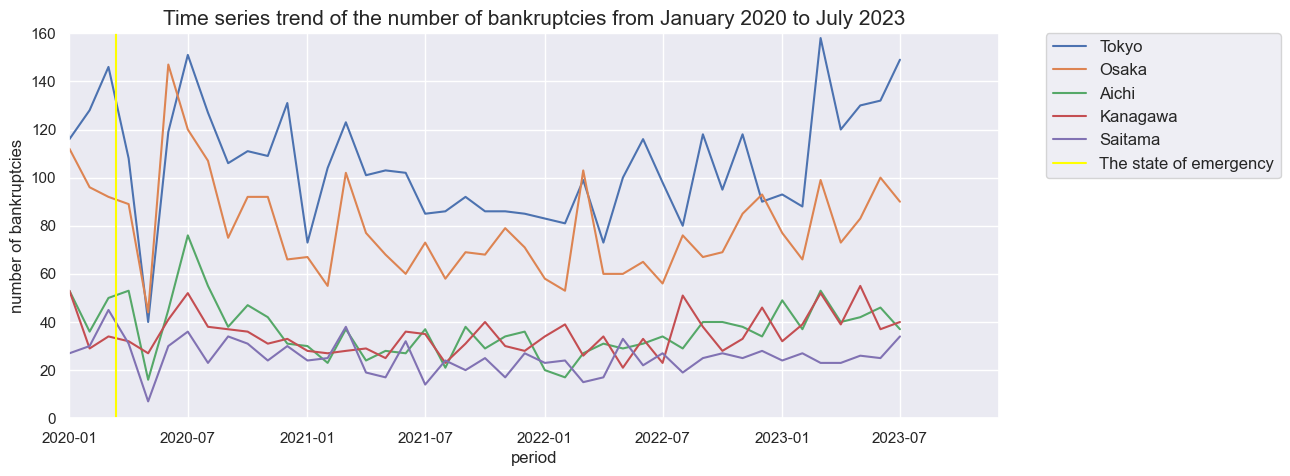

In [177]:
#Time series trend from Jan 2020 to July 2023

sns.set()


plt.figure(figsize=(12, 5))

plt.xlabel("period")
plt.ylabel("number of bankruptcies")
plt.plot(nob2["period"], nob2["nob_Tokyo"], label='Tokyo')
plt.plot(nob2["period"], nob2["nob_Osaka"], label='Osaka')
plt.plot(nob2["period"], nob2["nob_Aichi"], label='Aichi')
plt.plot(nob2["period"], nob2["nob_Kanagawa"], label='Kanagawa')
plt.plot(nob2["period"], nob2["nob_Saitama"], label='Saitama')

plt.xlim(pd.Timestamp("2020-01-01"), pd.Timestamp("2023-12-1"))
plt.ylim(0, 160)

vertical_line_date = pd.to_datetime('2020-03-13')

plt.axvline(x=vertical_line_date, color='yellow', linestyle='-', label='The state of emergency')


plt.legend()

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)

plt.title('Time series trend of the number of bankruptcies from January 2020 to July 2023', fontsize=15)


plt.show()

The second is the impact of the COVID-19 pandemic that began around the beginning of 2020. Since the financial crisis, the number of bankruptcies has been on a downward trend, but since March 2020, there has been a slight increase in the number of bankruptcies. One interesting point is that a highly steep decrease in the number of bankruptcies is observed around May 2020. This could be due to the fact that the Japanese government declared a state of emergency just prior to this time and provided support funds to companies that were forced to close their businesses or whose financial conditions had deteriorated significantly. In Tokyo, the recent increase in the number of firms is particularly noticeable, but this can be attributed to macroeconomic factors other than the pandemic. In any case, we observe a nonlinear trend in the number of bankruptcies.

In this report, the data will be divided into training and test data, and the analysis will take the form of how to predict the test data based on the training data.

In [139]:
np.random.seed(816)

random_indices = np.sort(np.random.choice(len(nob2), size=round(len(nob2)/3), replace=False))
random_indices

nob2["num"] = range(1,len(nob2)+1)

#train data
train_data = nob2[nob2['num'].isin(random_indices)]
display(train_data.shape)
train_data

(72, 22)

,period,area code_x,city name_x,nob_Tokyo,note_x,area code_y,city name_y,nob_Osaka,note_y,area code_x,...,note_x,area code_y,city name_y,nob_Kanagawa,note_y,area code,city name,nob_Saitama,note,num
1,2005-08-01,13000,Tokyo,210,NaN,27000,Osaka,191,NaN,23000,...,NaN,14000,Kanagawa,57,NaN,11000,Saitama,24,NaN,2
4,2005-11-01,13000,Tokyo,178,NaN,27000,Osaka,208,NaN,23000,...,NaN,14000,Kanagawa,54,NaN,11000,Saitama,37,NaN,5
8,2006-03-01,13000,Tokyo,232,NaN,27000,Osaka,183,NaN,23000,...,NaN,14000,Kanagawa,54,NaN,11000,Saitama,41,NaN,9
11,2006-06-01,13000,Tokyo,181,NaN,27000,Osaka,200,NaN,23000,...,NaN,14000,Kanagawa,54,NaN,11000,Saitama,26,NaN,12
14,2006-09-01,13000,Tokyo,163,NaN,27000,Osaka,168,NaN,23000,...,NaN,14000,Kanagawa,38,NaN,11000,Saitama,29,NaN,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,2022-03-01,13000,Tokyo,99,NaN,27000,Osaka,103,NaN,23000,...,NaN,14000,Kanagawa,26,NaN,11000,Saitama,15,NaN,201
203,2022-06-01,13000,Tokyo,116,NaN,27000,Osaka,65,NaN,23000,...,NaN,14000,Kanagawa,33,NaN,11000,Saitama,22,NaN,204
204,2022-07-01,13000,Tokyo,98,NaN,27000,Osaka,56,NaN,23000,...,NaN,14000,Kanagawa,23,NaN,11000,Saitama,27,NaN,205
205,2022-08-01,13000,Tokyo,80,NaN,27000,Osaka,76,NaN,23000,...,NaN,14000,Kanagawa,51,NaN,11000,Saitama,19,NaN,206


In [140]:
#test data
test_data = nob2[~nob2['num'].isin(random_indices)]
display(test_data.shape)
test_data

(145, 22)

,period,area code_x,city name_x,nob_Tokyo,note_x,area code_y,city name_y,nob_Osaka,note_y,area code_x,...,note_x,area code_y,city name_y,nob_Kanagawa,note_y,area code,city name,nob_Saitama,note,num
0,2005-07-01,13000,Tokyo,169,NaN,27000,Osaka,173,NaN,23000,...,NaN,14000,Kanagawa,60,NaN,11000,Saitama,41,NaN,1
2,2005-09-01,13000,Tokyo,180,NaN,27000,Osaka,153,NaN,23000,...,NaN,14000,Kanagawa,44,NaN,11000,Saitama,39,NaN,3
3,2005-10-01,13000,Tokyo,201,NaN,27000,Osaka,220,NaN,23000,...,NaN,14000,Kanagawa,56,NaN,11000,Saitama,45,NaN,4
5,2005-12-01,13000,Tokyo,212,NaN,27000,Osaka,237,NaN,23000,...,NaN,14000,Kanagawa,46,NaN,11000,Saitama,40,NaN,6
6,2006-01-01,13000,Tokyo,219,NaN,27000,Osaka,188,NaN,23000,...,NaN,14000,Kanagawa,37,NaN,11000,Saitama,36,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,2023-03-01,13000,Tokyo,158,NaN,27000,Osaka,99,NaN,23000,...,NaN,14000,Kanagawa,52,NaN,11000,Saitama,23,NaN,213
213,2023-04-01,13000,Tokyo,120,NaN,27000,Osaka,73,NaN,23000,...,NaN,14000,Kanagawa,39,NaN,11000,Saitama,23,NaN,214
214,2023-05-01,13000,Tokyo,130,NaN,27000,Osaka,83,NaN,23000,...,NaN,14000,Kanagawa,55,NaN,11000,Saitama,26,NaN,215
215,2023-06-01,13000,Tokyo,132,NaN,27000,Osaka,100,NaN,23000,...,NaN,14000,Kanagawa,37,NaN,11000,Saitama,25,NaN,216


We randomly split the data into train data and test data at a 1:2 ratio.

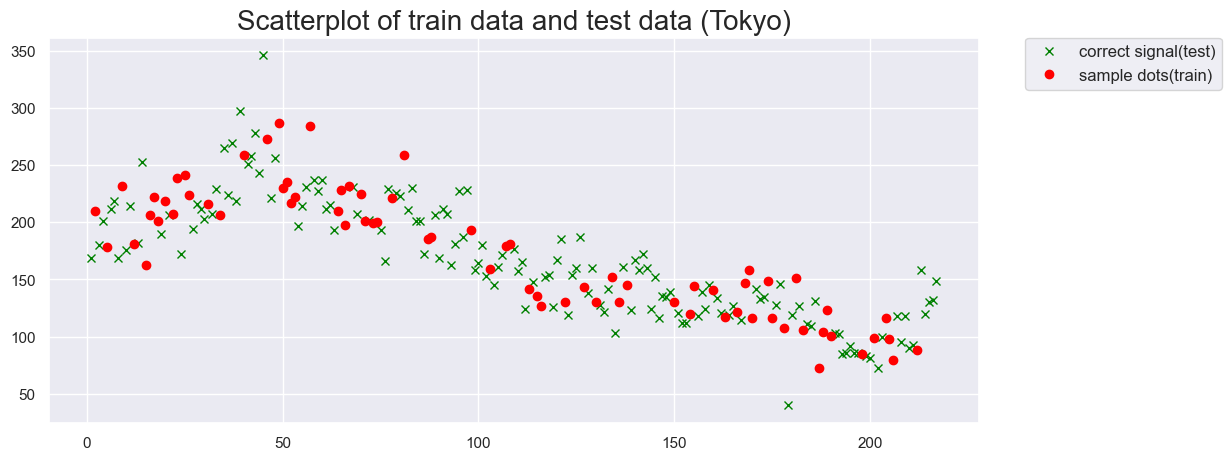

In [178]:
#scatterplot of Tokyo
sns.set()

plt.figure(figsize=(12, 5))
plt.title('Scatterplot of train data and test data (Tokyo)', fontsize=20)

plt.plot(test_data["num"], test_data["nob_Tokyo"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Tokyo"], 'o', color='red', label='sample dots(train)')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.show()


In the above graph, the red circle dots indicate the train data and the green cross dots indicate the test data. Prediction is based on a setting where only red data is at hand.

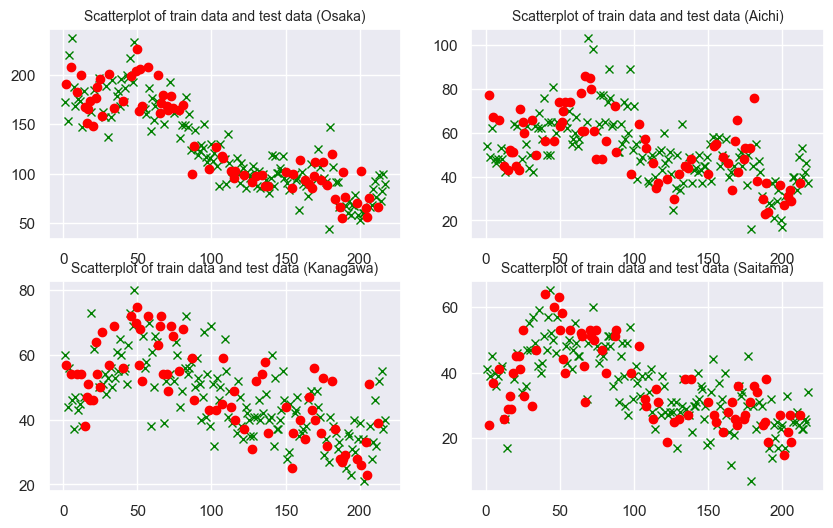

In [179]:
sns.set()

plt.figure(figsize=(10, 6))  

#Scatterplot of Osaka
plt.subplot(2, 2, 1)  
plt.title('Scatterplot of train data and test data (Osaka)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Osaka"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Osaka"], 'o', color='red', label='sample dots(train)')

#Scatterplot of Aichi
plt.subplot(2, 2, 2)  
plt.title('Scatterplot of train data and test data (Aichi)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Aichi"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Aichi"], 'o', color='red', label='sample dots(train)')

#Scatterplot of Kanagawa
plt.subplot(2, 2, 3)  
plt.title('Scatterplot of train data and test data (Kanagawa)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Kanagawa"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Kanagawa"], 'o', color='red', label='sample dots(train)')

#Scatterplot of Saitama
plt.subplot(2, 2, 4)  
plt.title('Scatterplot of train data and test data (Saitama)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Saitama"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Saitama"], 'o', color='red', label='sample dots(train)')

Other cities are as above.

**Data Analysis (Prediction)**

In this report, we use train data to perform regression analysis. Also, we do not make causal inferences to the number of bankruptcies for a particular variable by estimation, but predict the number of bankruptcies based on time series. First, we use the simplest single regression analysis to make predictions based on the model below. 


$$\text{$number$ $of$ $bankruptcies$}_t=\alpha +\beta t +\epsilon_t$$

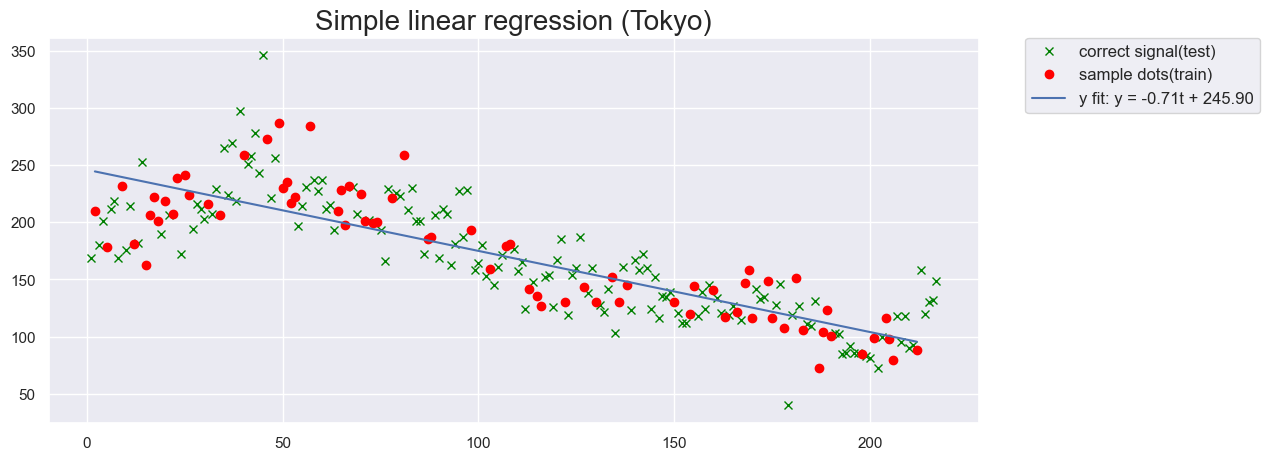

In [188]:
sns.set()

plt.figure(figsize=(12, 5))
plt.title('Simple linear regression (Tokyo)', fontsize=20)

plt.plot(test_data["num"], test_data["nob_Tokyo"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Tokyo"], 'o', color='red', label='sample dots(train)')

x=train_data["num"]
y=train_data["nob_Tokyo"]

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(x, y)
line1 = slope1 * train_data["num"] + intercept1
plt.plot(train_data["num"], line1, color='b', label=f'y fit: y = {slope1:.2f}t + {intercept1:.2f}')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)

plt.show()



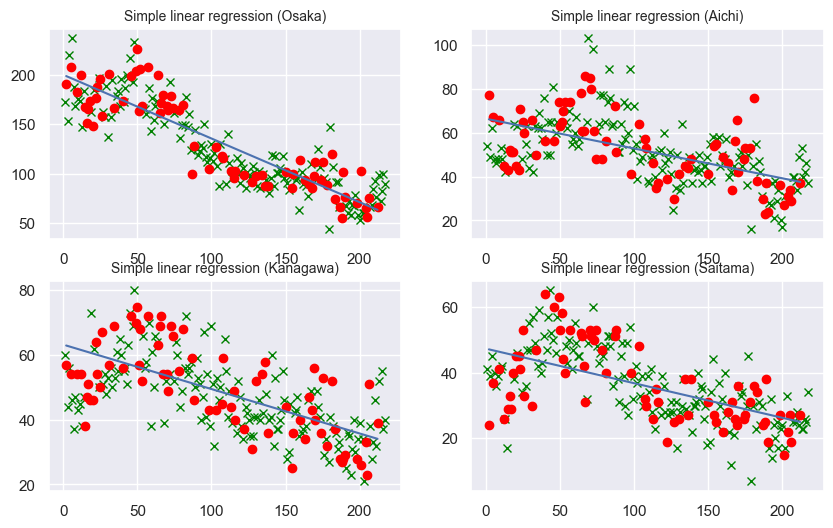

In [212]:
sns.set()

plt.figure(figsize=(10, 6))  

#Scatterplot of Osaka
plt.subplot(2, 2, 1)  
plt.title('Simple linear regression (Osaka)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Osaka"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Osaka"], 'o', color='red', label='sample dots(train)')

xo=train_data["num"]
yo=train_data["nob_Osaka"]

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(xo, yo)
line1 = slope1 * train_data["num"] + intercept1
plt.plot(train_data["num"], line1, color='b', label=f'y fit: y = {slope1:.2f}t + {intercept1:.2f}')

#Scatterplot of Aichi
plt.subplot(2, 2, 2)  
plt.title('Simple linear regression (Aichi)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Aichi"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Aichi"], 'o', color='red', label='sample dots(train)')

xa=train_data["num"]
ya=train_data["nob_Aichi"]

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(xa, ya)
line1 = slope1 * train_data["num"] + intercept1
plt.plot(train_data["num"], line1, color='b', label=f'y fit: y = {slope1:.2f}t + {intercept1:.2f}')

#Scatterplot of Kanagawa
plt.subplot(2, 2, 3)  
plt.title('Simple linear regression (Kanagawa)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Kanagawa"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Kanagawa"], 'o', color='red', label='sample dots(train)')

xk=train_data["num"]
yk=train_data["nob_Kanagawa"]

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(xk, yk)
line1 = slope1 * train_data["num"] + intercept1
plt.plot(train_data["num"], line1, color='b', label=f'y fit: y = {slope1:.2f}t + {intercept1:.2f}')

#Scatterplot of Saitama
plt.subplot(2, 2, 4)  
plt.title('Simple linear regression (Saitama)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Saitama"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Saitama"], 'o', color='red', label='sample dots(train)')

xs=train_data["num"]
ys=train_data["nob_Saitama"]

slope1, intercept1, r_value1, p_value1, std_err1 = linregress(xs, ys)
line1 = slope1 * train_data["num"] + intercept1
plt.plot(train_data["num"], line1, color='b', label=f'y fit: y = {slope1:.2f}t + {intercept1:.2f}')

Although single linear regression captures first-order trends in the data, it is not able to capture nonlinear trends. Even in a linear regression framework, fitting to train data can be improved by adding power terms and using multiple regression models with higher order polynomials. For example, a model with a fifth-order polynomial produces a nonlinear fitting curve.

$$\text{$number$ $of$ $bankruptcies$}_t=\alpha +\beta_1 t +\beta_2t^2 t+\beta_3t^3 +\beta_4t^4 +\beta_5t^5 + \epsilon_t$$

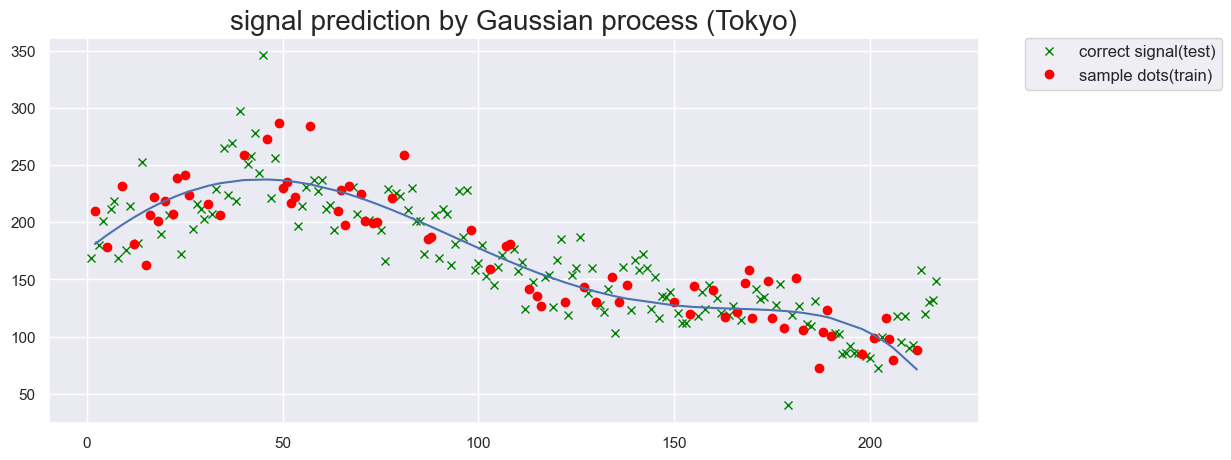

In [207]:
train_data["numsq"] = train_data["num"]**2
train_data["numpower3"] = train_data["num"]**3
train_data["numpower4"] = train_data["num"]**4
train_data["numpower5"] = train_data["num"]**5

X = train_data[['num', 'numsq','numpower3','numpower4','numpower5']]
y = train_data["nob_Tokyo"]

X = sm.add_constant(X)  
model = sm.OLS(y, X).fit()

plt.figure(figsize=(12, 5))
plt.title('Multiple linear regression (Tokyo)', fontsize=20)

plt.plot(test_data["num"], test_data["nob_Tokyo"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Tokyo"], 'o', color='red', label='sample dots(train)')

x=train_data["num"]
y=train_data["nob_Tokyo"]

curve=model.params['const']+model.params['num']*train_data["num"]+model.params['numsq']*train_data["numsq"]+model.params['numpower3']*train_data["numpower3"]+model.params['numpower4']*train_data["numpower4"]+model.params['numpower5']*train_data["numpower5"]
plt.plot(train_data["num"], curve, color='b')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.show()




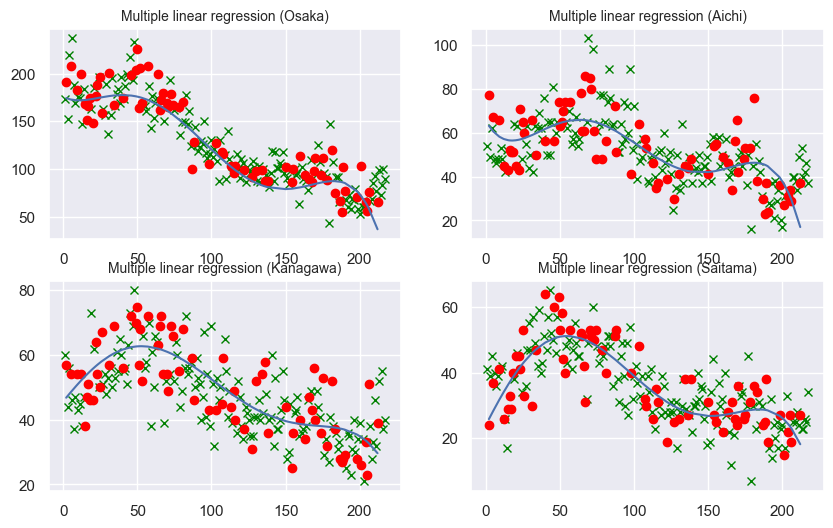

In [214]:
sns.set()

plt.figure(figsize=(10, 6))  

#Scatterplot of Osaka
plt.subplot(2, 2, 1)  
plt.title('Multiple linear regression (Osaka)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Osaka"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Osaka"], 'o', color='red', label='sample dots(train)')

yo=train_data["nob_Osaka"]
modelo = sm.OLS(yo, X).fit()

curve=model.params['const']+modelo.params['num']*train_data["num"]+modelo.params['numsq']*train_data["numsq"]+modelo.params['numpower3']*train_data["numpower3"]+modelo.params['numpower4']*train_data["numpower4"]+modelo.params['numpower5']*train_data["numpower5"]
plt.plot(train_data["num"], curve, color='b')

#Scatterplot of Aichi
plt.subplot(2, 2, 2)  
plt.title('Multiple linear regression (Aichi)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Aichi"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Aichi"], 'o', color='red', label='sample dots(train)')

ya=train_data["nob_Aichi"]
modela = sm.OLS(ya, X).fit()

curve=modela.params['const']+modela.params['num']*train_data["num"]+modela.params['numsq']*train_data["numsq"]+modela.params['numpower3']*train_data["numpower3"]+modela.params['numpower4']*train_data["numpower4"]+modela.params['numpower5']*train_data["numpower5"]
plt.plot(train_data["num"], curve, color='b')

#Scatterplot of Kanagawa
plt.subplot(2, 2, 3)  
plt.title('Multiple linear regression (Kanagawa)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Kanagawa"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Kanagawa"], 'o', color='red', label='sample dots(train)')

yk=train_data["nob_Kanagawa"]
modelk = sm.OLS(yk, X).fit()

curve=modelk.params['const']+modelk.params['num']*train_data["num"]+modelk.params['numsq']*train_data["numsq"]+modelk.params['numpower3']*train_data["numpower3"]+modelk.params['numpower4']*train_data["numpower4"]+modelk.params['numpower5']*train_data["numpower5"]
plt.plot(train_data["num"], curve, color='b')


#Scatterplot of Saitama
plt.subplot(2, 2, 4)  
plt.title('Multiple linear regression (Saitama)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Saitama"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Saitama"], 'o', color='red', label='sample dots(train)')

ys=train_data["nob_Saitama"]
models = sm.OLS(ys, X).fit()

curve=models.params['const']+models.params['num']*train_data["num"]+models.params['numsq']*train_data["numsq"]+models.params['numpower3']*train_data["numpower3"]+models.params['numpower4']*train_data["numpower4"]+models.params['numpower5']*train_data["numpower5"]
plt.plot(train_data["num"], curve, color='b')

Compared to the simple linear regression described earlier, the fit to the test data appears to be improved in both cases. However, if more power terms are added, overfitting may occur, so that regularized model with a penalty term such as ridge and lasso regression should be used.

**Gaussian process regression**

Gaussian process regression is a nonparametric method, which means that it can capture nonlinear trends in the trend. A Gaussian process is a type of stochastic process, which gives a (simultaneous) probability distribution to a set of random variables corresponding to a set of inputs that can often be ordered in time. A Gaussian process is a type of stochastic process, which gives a (simultaneous) probability distribution to a set of random variables corresponding to a set of inputs that can often be ordered in time. The observed data, which are the output of the Gaussian process, follow a multivariate gaussian (normal) distribution, and the covariance of each observed data is higher whenever the different input $x$ values are closer in the Gaussian process. The observed data are determined by the elements of the covariance matrix that make up this multivariate normal distribution, and by applying a mathematical technique called the kernel trick, the distribution can be determined only by calculating a kernel function $k(x_t,x_{t'})$that indicates the corresponding covariance matrix elements from different inputs $x$. There are various types of kernel functions, but this report uses the following kernel functions, called Gaussian kernel or Radial Basis Function (RBF).
$$k(x,x')=\theta_1 exp(-\frac{(x-x')^2}{\theta_2})$$
It is easy to see that the closer the value of x is, the greater the value of RBF. Then $\theta_1$ and $\theta_2$ are hyper parameters that are set in advance. In Gaussian process regression, the parameter-based kernel function is explicitly shown as follows.
$$k(x,x'|\theta_1,\theta_2,\theta_3)=\theta_1 exp(-\frac{(x-x')^2}{\theta_2})+\theta_3\delta(x,x') $$
The function $\delta(x,x')$ added to the RBF mentioned earlier is a function that indicates 1 when $x=x'$ and 0 otherwise, indicating noise in the actual observed values. The likelihood function of the observed data $p(\bf{y}|X,\theta)$ is determined by the covariance matrix $K_{\theta}$, which is constructed by the kernel function conditioned on $\theta$.
$$p(\bf{y}|X,\theta)=\mathcal{N}(\bf{y}|\bf{\mu},K_{\theta})$$
$$=\frac{1}{(2\pi)^{N/2}}\frac{1}{|K_{\theta}|^{1/2}}exp(-\frac{1}{2}\bf{y}^TK_{\theta}^{-1})y$$

We need to find the $\theta$ that maximizes this likelihood function, and there are two methods to explore the best parameters: Markov chain Monte Calro method (MCMC) and the Gradient Decent (GD) method .　In the MCMC, the parameters are obtained numerically by generating the posterior distribution according to a Markov chain. The GD method uses the gradient of a specific point and keep updating the value of it to find the optimal parameters numerically. This report uses both methods.


In [237]:
#rbf
def rbf(x, x_prime, theta_1, theta_2):    
    return theta_1 * np.exp(-1 * (x - x_prime)**2 / theta_2)

#kernel function
def kernel(x, x_prime, theta_1, theta_2, theta_3, noise, eval_grad=False):
    # delta function
    if noise:
        delta = theta_3
    else:
        delta = 0

    if eval_grad:
        dk_dTheta_2 = (kernel(x, x_prime, theta_1, theta_2, theta_3, noise) - delta) * ((x - x_prime)**2) / theta_2
        dk_dTheta_3 = delta

        return rbf(x, x_prime, theta_1=theta_1, theta_2=theta_2) + \
            delta, np.array([dk_dTheta_1, dk_dTheta_2, dk_dTheta_3])

    return rbf(x, x_prime, theta_1=theta_1, theta_2=theta_2) + delta


#MCMC
def MCMCoptimize(x_train, y_train, bounds, initial_params=np.ones(3), n_iter=1000):
    params = initial_params
    bounds = np.atleast_2d(bounds)

    # log transformation
    log_params = np.log(params)
    log_bounds = np.log(bounds)
    log_scale = log_bounds[:, 1] - log_bounds[:, 0]

    def log_marginal_likelihood(params):
        train_length = len(x_train)
        K = np.zeros((train_length, train_length))
        for x_idx in range(train_length):
            for x_prime_idx in range(train_length):
                K[x_idx, x_prime_idx] = kernel(x_train[x_idx], x_train[x_prime_idx],
                                               params[0], params[1], params[2], x_idx == x_prime_idx)

        y = y_train
        yy = np.dot(np.linalg.inv(K), y_train)
        return - (np.linalg.slogdet(K)[1] + np.dot(y, yy))

    lml_prev = log_marginal_likelihood(params)

    thetas_list = []
    lml_list = []
    for _ in range(n_iter):
        move = 1e-2 * np.random.normal(0, log_scale, size=len(params))

        need_resample = (log_params +
                         move < log_bounds[:, 0]) | (log_params +
                                                     move > log_bounds[:, 1])

        while(np.any(need_resample)):
            move[need_resample] = np.random.normal(0, log_scale, size=len(params))[need_resample]
            need_resample = (log_params +
                             move < log_bounds[:, 0]) | (log_params +
                                                         move > log_bounds[:, 1])

        # proposed distribution
        next_log_params = log_params + move
        next_params = np.exp(next_log_params)
        lml_next = log_marginal_likelihood(next_params)

        r = np.exp(lml_next - lml_prev)

        # metropolis update
        if r > 1 or r > np.random.random():
            params = next_params
            log_params = next_log_params
            lml_prev = lml_next
            thetas_list.append(params)
            lml_list.append(lml_prev)

    return thetas_list[np.argmax(lml_list)]

First we generate the RBF function and kernel function. First we generate the RBF function and kernel function. Then, MCMC defines the log-likelihood function and performs an approximate calculation of the integral using the Metropolis-Hastings algorithm (M-H algorithm).

In [267]:
#Gardient Decent Method

# Radiant Basis Kernel + Error
def kernel(x, x_prime, theta_1, theta_2, theta_3, noise, eval_grad=False):
    # delta function
    if noise:
        delta = theta_3
    else:
        delta = 0

    if eval_grad:
        dk_dTheta_1 = kernel(x, x_prime, theta_1, theta_2, theta_3, noise) - delta
        dk_dTheta_2 = (kernel(x, x_prime, theta_1, theta_2, theta_3, noise) - delta) * ((x - x_prime)**2) / theta_2
        dk_dTheta_3 = delta

        return rbf(x, x_prime, theta_1=theta_1, theta_2=theta_2) + \
            delta, np.array([dk_dTheta_1, dk_dTheta_2, dk_dTheta_3])

    return rbf(x, x_prime, theta_1=theta_1, theta_2=theta_2) + delta

def GDoptimized(x_train, y_train, bounds, initial_params=np.ones(3)):
    bounds = np.atleast_2d(bounds)

    def log_marginal_likelihood(params):
        train_length = len(x_train)
        K = np.zeros((train_length, train_length))
        for x_idx in range(train_length):
            for x_prime_idx in range(train_length):
                K[x_idx, x_prime_idx] = kernel(
                    x_train[x_idx], x_train[x_prime_idx], params[0], params[1], params[2], x_idx == x_prime_idx)

        yy = np.dot(np.linalg.inv(K), y_train)
        return - (np.linalg.slogdet(K)[1] + np.dot(y_train, yy))

    def log_likelihood_gradient(params):
        train_length = len(x_train)
        K = np.zeros((train_length, train_length))
        dK_dTheta = np.zeros((3, train_length, train_length))
        for x_idx in range(train_length):
            for x_prime_idx in range(train_length):
                k, grad = kernel(x_train[x_idx], x_train[x_prime_idx], params[0],
                                 params[1], params[2], x_idx == x_prime_idx, eval_grad=True)
                K[x_idx, x_prime_idx] = k
                dK_dTheta[0, x_idx, x_prime_idx] = grad[0]
                dK_dTheta[1, x_idx, x_prime_idx] = grad[1]
                dK_dTheta[2, x_idx, x_prime_idx] = grad[2]

        K_inv = np.linalg.inv(K)
        yy = np.dot(K_inv, y_train)
        tr = np.einsum("ijj", np.einsum("ij,kjl->kil", K_inv, dK_dTheta))
        return - tr + np.einsum("i,ji->j", yy.T, np.einsum("ijk,k->ij", dK_dTheta, yy))

    def obj_func(params):
        lml = log_marginal_likelihood(params)
        grad = log_likelihood_gradient(params)
        return -lml, -grad

    opt_res = scipy.optimize.minimize(
        obj_func,
        initial_params,
        method="L-BFGS-B",
        jac=True,
        bounds=bounds,
    )

    theta_opt, func_min = opt_res.x, opt_res.fun
    return theta_opt, func_min




In the GD Method, scipy's optimize function is used in the GD function defined.

In [268]:
num_train_data = train_data["num"].values 
nob_Tokyo_train= train_data["nob_Tokyo"]
nob_Osaka_train= train_data["nob_Osaka"]
nob_Aichi_train= train_data["nob_Aichi"]
nob_Kanagawa_train= train_data["nob_Kanagawa"]
nob_Saitama_train= train_data["nob_Saitama"]

mcmcthetas_Tokyo = MCMCoptimize(num_train_data, nob_Tokyo_train, bounds=np.array(
        [[1e-3, 1e3], [1e-2, 1e2], [1e-2, 1e2]]), initial_params=np.array([10, 10, 10]))
mcmcthetas_Osaka = MCMCoptimize(num_train_data, nob_Tokyo_train, bounds=np.array(
        [[1e-3, 1e3], [1e-2, 1e2], [1e-2, 1e2]]), initial_params=np.array([10, 10, 10]))
mcmcthetas_Aichi = MCMCoptimize(num_train_data, nob_Tokyo_train, bounds=np.array(
        [[1e-3, 1e3], [1e-2, 1e2], [1e-2, 1e2]]), initial_params=np.array([10, 10, 10]))
mcmcthetas_Kanagawa = MCMCoptimize(num_train_data, nob_Tokyo_train, bounds=np.array(
        [[1e-3, 1e3], [1e-2, 1e2], [1e-2, 1e2]]), initial_params=np.array([10, 10, 10]))
mcmcthetas_Saitama = MCMCoptimize(num_train_data, nob_Tokyo_train, bounds=np.array(
        [[1e-3, 1e3], [1e-2, 1e2], [1e-2, 1e2]]), initial_params=np.array([10, 10, 10]))
print(mcmcthetas_Tokyo)
print(mcmcthetas_Osaka)
print(mcmcthetas_Aichi)
print(mcmcthetas_Kanagawa)
print(mcmcthetas_Saitama)

/var/folders/_5/f24l1pqx5dg1hk_d0r3fhr_00000gn/T/ipykernel_61308/1139479204.py:65: RuntimeWarning: overflow encountered in exp
  r = np.exp(lml_next - lml_prev)


[997.19243012  97.95422208  99.59352648]
[977.35995348  95.40459014  99.0325142 ]
[995.29923768  98.75377118  96.430271  ]
[989.21921953  96.15327791  97.47085192]
[990.45658813  94.70803831  98.96710271]


In [251]:
GDthetas_Tokyo = GDoptimized(num_train_data, nob_Tokyo_train, bounds=np.array(
        [[1e-3, 1e3], [1e-2, 1e2], [1e-2, 1e2]]), initial_params=np.array([10, 10, 10]))
GDthetas_Osaka = GDoptimized(num_train_data, nob_Osaka_train, bounds=np.array(
        [[1e-3, 1e3], [1e-2, 1e2], [1e-2, 1e2]]), initial_params=np.array([10, 10, 10]))
GDthetas_Aichi = GDoptimized(num_train_data, nob_Aichi_train, bounds=np.array(
        [[1e-3, 1e3], [1e-2, 1e2], [1e-2, 1e2]]), initial_params=np.array([10, 10, 10]))
GDthetas_Kanagawa = GDoptimized(num_train_data, nob_Kanagawa_train, bounds=np.array(
        [[1e-3, 1e3], [1e-2, 1e2], [1e-2, 1e2]]), initial_params=np.array([10, 10, 10]))
GDthetas_Saitama = GDoptimized(num_train_data, nob_Saitama_train, bounds=np.array(
        [[1e-3, 1e3], [1e-2, 1e2], [1e-2, 1e2]]), initial_params=np.array([10, 10, 10]))

print(GDthetas_Tokyo)
print(GDthetas_Osaka)
print(GDthetas_Aichi)
print(GDthetas_Kanagawa)
print(GDthetas_Saitama)

[1000.  100.  100.]
[1000.  100.  100.]
[1000.          100.           74.49108567]
[1000.          100.           64.52178553]
[796.63382637 100.          34.15917107]


Both methods output generally similar results, but these appear to be on the edge of the specified upper limit　values. These are pre-stretched as hyperparameters, and then Gaussian process regression is performed.

In [269]:
def kernel(x, xd):    
    K = np.zeros([len(x), len(xd)])
    for i, j in product(range(len(x)), range(len(xd))):
        K[i][j] = theta[0]*np.exp(-1*(x[i] - xd[j])**2 /theta[1])+(theta[2]*int(x[i]==xd[j]))
    return K

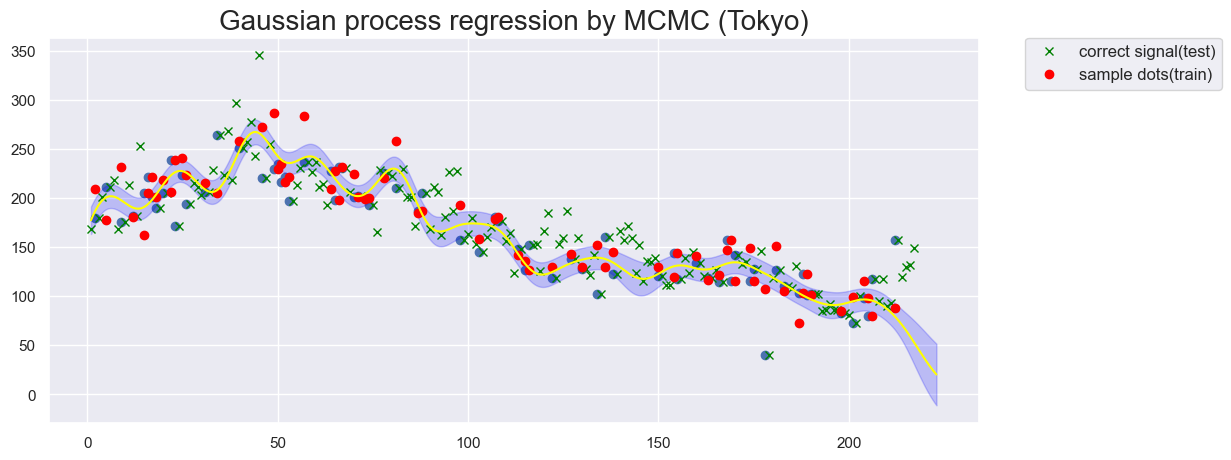

In [270]:
Tokyo_trained=train_data["nob_Tokyo"].values
num_trained = train_data["num"].values 

theta = mcmcthetas_Tokyo
X_est = np.linspace(1, 223, 3000)  
std = np.zeros([len(X_est)]) 
K=kernel(num_trained,num_trained)
W = np.dot(np.linalg.inv(K),train_data["nob_Tokyo"])
k = kernel(X_est, num_trained)
mu = np.dot(k, W) 
KK = np.dot(k, np.linalg.inv(K))

for i in range(len(X_est)):
    std[i] = np.sqrt(theta[0] + theta[2] - np.dot(KK[i], k[i].T))
plt.figure(figsize=(12, 5))
plt.title('Gaussian process regression by MCMC (Tokyo)', fontsize=20)

plt.plot(test_data["num"], test_data["nob_Tokyo"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Tokyo"], 'o', color='red', label='sample dots(train)')

plt.scatter(num_trained, trained["nob_Tokyo"])
plt.plot(X_est, mu, color='yellow')        
plt.fill_between(X_est, mu + std, mu - std, alpha=.2, color='blue') 


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.show()


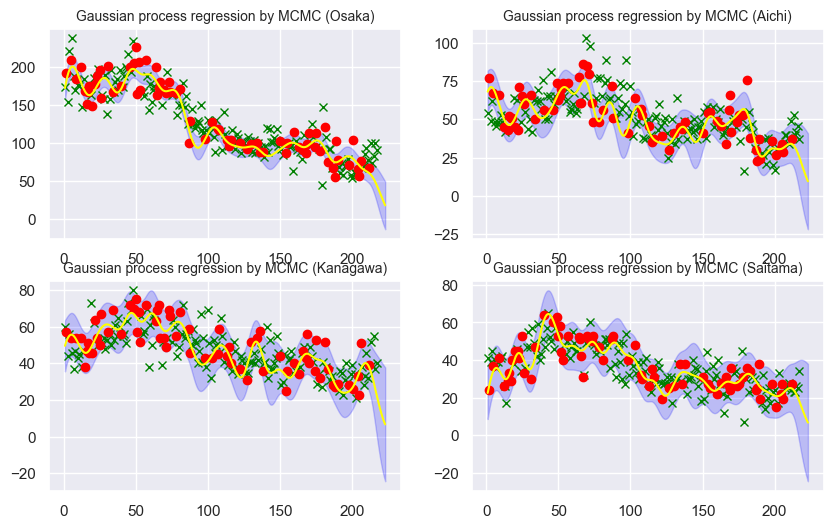

In [265]:
sns.set()

plt.figure(figsize=(10, 6))  

#Scatterplot of Osaka
plt.subplot(2, 2, 1)  

Osaka_trained=train_data["nob_Osaka"].values

theta = mcmcthetas_Osaka
X_est = np.linspace(1, 223, 3000)  
std = np.zeros([len(X_est)]) 
K=kernel(num_trained,num_trained)
W = np.dot(np.linalg.inv(K),train_data["nob_Osaka"])
k = kernel(X_est, num_trained)
mu = np.dot(k, W) 
KK = np.dot(k, np.linalg.inv(K))

for i in range(len(X_est)):
    std[i] = np.sqrt(theta[0] + theta[2] - np.dot(KK[i], k[i].T))
plt.title('Gaussian process regression by MCMC (Osaka)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Osaka"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Osaka"], 'o', color='red', label='sample dots(train)')

plt.plot(X_est, mu, color='yellow')        
plt.fill_between(X_est, mu + std, mu - std, alpha=.2, color='blue') 

#Scatterplot of Aichi
plt.subplot(2, 2, 2)  
Aichi_trained=train_data["nob_Aichi"].values

theta = mcmcthetas_Aichi
X_est = np.linspace(1, 223, 3000)  
std = np.zeros([len(X_est)]) 
K=kernel(num_trained,num_trained)
W = np.dot(np.linalg.inv(K),train_data["nob_Aichi"])
k = kernel(X_est, num_trained)
mu = np.dot(k, W) 
KK = np.dot(k, np.linalg.inv(K))

for i in range(len(X_est)):
    std[i] = np.sqrt(theta[0] + theta[2] - np.dot(KK[i], k[i].T))
plt.title('Gaussian process regression by MCMC (Aichi)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Aichi"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Aichi"], 'o', color='red', label='sample dots(train)')

plt.plot(X_est, mu, color='yellow')        
plt.fill_between(X_est, mu + std, mu - std, alpha=.2, color='blue') 


#Scatterplot of Kanagawa
plt.subplot(2, 2, 3)  
Kanagawa_trained=train_data["nob_Kanagawa"].values

theta = mcmcthetas_Kanagawa
X_est = np.linspace(1, 223, 3000)  
std = np.zeros([len(X_est)]) 
K=kernel(num_trained,num_trained)
W = np.dot(np.linalg.inv(K),train_data["nob_Kanagawa"])
k = kernel(X_est, num_trained)
mu = np.dot(k, W) 
KK = np.dot(k, np.linalg.inv(K))

for i in range(len(X_est)):
    std[i] = np.sqrt(theta[0] + theta[2] - np.dot(KK[i], k[i].T))
plt.title('Gaussian process regression by MCMC (Kanagawa)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Kanagawa"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Kanagawa"], 'o', color='red', label='sample dots(train)')

plt.plot(X_est, mu, color='yellow')        
plt.fill_between(X_est, mu + std, mu - std, alpha=.2, color='blue') 


#Scatterplot of Saitama
plt.subplot(2, 2, 4)  
Saitama_trained=train_data["nob_Saitama"].values

theta = mcmcthetas_Saitama
X_est = np.linspace(1, 223, 3000)  
std = np.zeros([len(X_est)]) 
K=kernel(num_trained,num_trained)
W = np.dot(np.linalg.inv(K),train_data["nob_Saitama"])
k = kernel(X_est, num_trained)
mu = np.dot(k, W) 
KK = np.dot(k, np.linalg.inv(K))

for i in range(len(X_est)):
    std[i] = np.sqrt(theta[0] + theta[2] - np.dot(KK[i], k[i].T))
plt.title('Gaussian process regression by MCMC (Saitama)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Saitama"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Saitama"], 'o', color='red', label='sample dots(train)')

plt.plot(X_est, mu, color='yellow')        
plt.fill_between(X_est, mu + std, mu - std, alpha=.2, color='blue') 

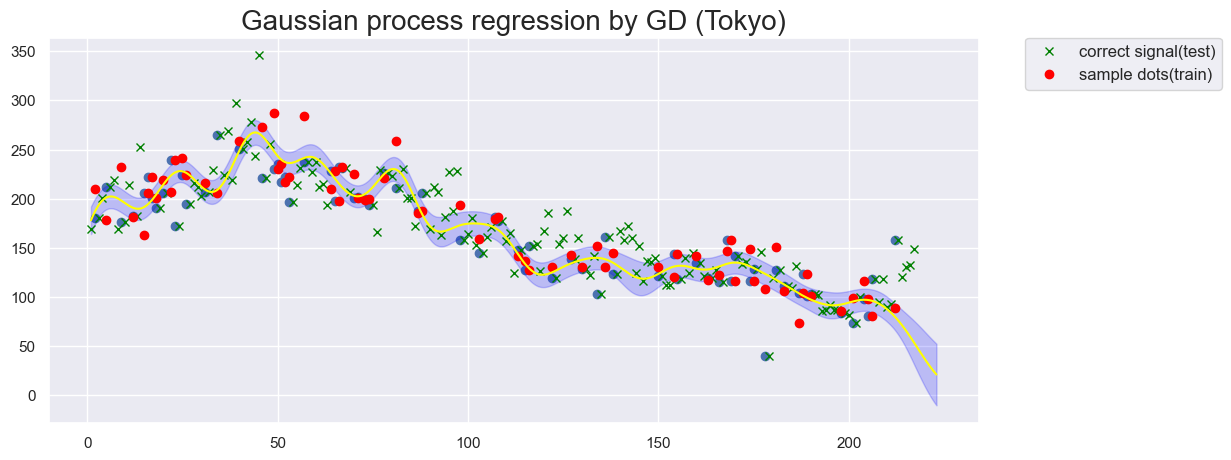

In [271]:
Tokyo_trained=train_data["nob_Tokyo"].values
num_trained = train_data["num"].values 

theta = GDthetas_Tokyo
X_est = np.linspace(1, 223, 3000)  
std = np.zeros([len(X_est)]) 
K=kernel(num_trained,num_trained)
W = np.dot(np.linalg.inv(K),train_data["nob_Tokyo"])
k = kernel(X_est, num_trained)
mu = np.dot(k, W) 
KK = np.dot(k, np.linalg.inv(K))

for i in range(len(X_est)):
    std[i] = np.sqrt(theta[0] + theta[2] - np.dot(KK[i], k[i].T))
plt.figure(figsize=(12, 5))
plt.title('Gaussian process regression by GD (Tokyo)', fontsize=20)

plt.plot(test_data["num"], test_data["nob_Tokyo"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Tokyo"], 'o', color='red', label='sample dots(train)')

plt.scatter(num_trained, trained["nob_Tokyo"])
plt.plot(X_est, mu, color='yellow')        
plt.fill_between(X_est, mu + std, mu - std, alpha=.2, color='blue') 


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
plt.show()

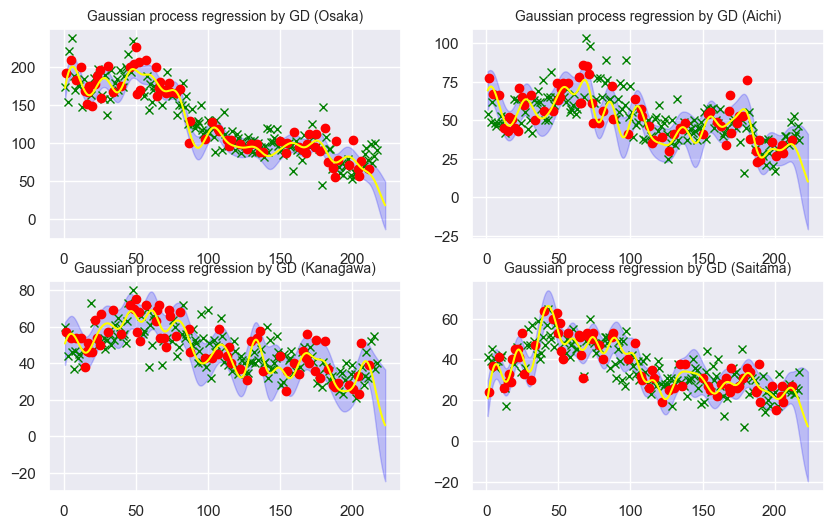

In [272]:
sns.set()

plt.figure(figsize=(10, 6))  

#Scatterplot of Osaka
plt.subplot(2, 2, 1)  

Osaka_trained=train_data["nob_Osaka"].values

theta = GDthetas_Osaka
X_est = np.linspace(1, 223, 3000)  
std = np.zeros([len(X_est)]) 
K=kernel(num_trained,num_trained)
W = np.dot(np.linalg.inv(K),train_data["nob_Osaka"])
k = kernel(X_est, num_trained)
mu = np.dot(k, W) 
KK = np.dot(k, np.linalg.inv(K))

for i in range(len(X_est)):
    std[i] = np.sqrt(theta[0] + theta[2] - np.dot(KK[i], k[i].T))
plt.title('Gaussian process regression by GD (Osaka)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Osaka"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Osaka"], 'o', color='red', label='sample dots(train)')

plt.plot(X_est, mu, color='yellow')        
plt.fill_between(X_est, mu + std, mu - std, alpha=.2, color='blue') 

#Scatterplot of Aichi
plt.subplot(2, 2, 2)  
Aichi_trained=train_data["nob_Aichi"].values

theta = GDthetas_Aichi
X_est = np.linspace(1, 223, 3000)  
std = np.zeros([len(X_est)]) 
K=kernel(num_trained,num_trained)
W = np.dot(np.linalg.inv(K),train_data["nob_Aichi"])
k = kernel(X_est, num_trained)
mu = np.dot(k, W) 
KK = np.dot(k, np.linalg.inv(K))

for i in range(len(X_est)):
    std[i] = np.sqrt(theta[0] + theta[2] - np.dot(KK[i], k[i].T))
plt.title('Gaussian process regression by GD (Aichi)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Aichi"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Aichi"], 'o', color='red', label='sample dots(train)')

plt.plot(X_est, mu, color='yellow')        
plt.fill_between(X_est, mu + std, mu - std, alpha=.2, color='blue') 


#Scatterplot of Kanagawa
plt.subplot(2, 2, 3)  
Kanagawa_trained=train_data["nob_Kanagawa"].values

theta = GDthetas_Kanagawa
X_est = np.linspace(1, 223, 3000)  
std = np.zeros([len(X_est)]) 
K=kernel(num_trained,num_trained)
W = np.dot(np.linalg.inv(K),train_data["nob_Kanagawa"])
k = kernel(X_est, num_trained)
mu = np.dot(k, W) 
KK = np.dot(k, np.linalg.inv(K))

for i in range(len(X_est)):
    std[i] = np.sqrt(theta[0] + theta[2] - np.dot(KK[i], k[i].T))
plt.title('Gaussian process regression by GD (Kanagawa)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Kanagawa"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Kanagawa"], 'o', color='red', label='sample dots(train)')

plt.plot(X_est, mu, color='yellow')        
plt.fill_between(X_est, mu + std, mu - std, alpha=.2, color='blue') 


#Scatterplot of Saitama
plt.subplot(2, 2, 4)  
Saitama_trained=train_data["nob_Saitama"].values

theta = GDthetas_Saitama
X_est = np.linspace(1, 223, 3000)  
std = np.zeros([len(X_est)]) 
K=kernel(num_trained,num_trained)
W = np.dot(np.linalg.inv(K),train_data["nob_Saitama"])
k = kernel(X_est, num_trained)
mu = np.dot(k, W) 
KK = np.dot(k, np.linalg.inv(K))

for i in range(len(X_est)):
    std[i] = np.sqrt(theta[0] + theta[2] - np.dot(KK[i], k[i].T))
plt.title('Gaussian process regression by GD (Saitama)', fontsize=10)

plt.plot(test_data["num"], test_data["nob_Saitama"], 'x', color='green', label='correct signal(test)')
plt.plot(train_data["num"], train_data["nob_Saitama"], 'o', color='red', label='sample dots(train)')

plt.plot(X_est, mu, color='yellow')        
plt.fill_between(X_est, mu + std, mu - std, alpha=.2, color='blue') 

Above are the results of the Gaussian process regression for each city; two patterns were used, MCMC and GD, but the results are almost identical. The yellow curve connects the expected values at each point obtained by the regression, and the blue area shows the error range of the posterior distribution based on Bayes Inference. The expected value curve has finer variation than the multiple regression described earlier. The remarkable point in Gaussian regression is that the error range varies from point to point: the error range is narrower at points with abundant train data, while it is wider at points with less abundant train data. In other words, Gaussian process regression can explicitly indicate the areas where the prediction is confident and the areas where the prediction is not confident.

Once again, when we check the accuracy of the prediction, it appears that the error region contains a reasonable amount of test data. However, quite many data are closed away from the forecast at points where the number of bankruptcies is highly volatile and at points where the number of bankruptcies changes rapidly due to the financial crisis and pandemic support payments. It is also interesting to note that the forecast is down after July 2023. We suppose this is because we did not have train data for the most recent high bankruptcy month on hand. The movement of sampling in the areas with no data is also related to the type of kernel function that is set first, and RBF has a relatively gradual movement compared to other common kernels.

**Conclusion**

In predicting the number of bankruptcies in a particular region, Gaussian process regression can also adjust the error range, so we may conclude that it is a relatively good model when data at hand is scarce and uncertainty is high.
